In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 定义站点名称
station_name = "五里湖心"

# 读取CSV文件
df = pd.read_csv(f'/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/000-weather_data_{station_name}.csv')

# 将time列转换为datetime格式
df['date'] = pd.to_datetime(df['time'].astype(str), format='%Y%m%d')

# 获取日期范围
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')

# 创建完整的日期DataFrame
complete_df = pd.DataFrame({'date': date_range})

# 与原始数据合并,保留所有日期
df_filled = pd.merge(complete_df, df, on='date', how='left')

# 将缺失值填充为NaN
df_filled = df_filled.fillna(np.nan)

# 读取站点数据
station_df = pd.read_csv(f'/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/001-{station_name}.csv')
station_df['date'] = pd.to_datetime(station_df['date'])

# 将两个数据集按日期合并
merged_df = pd.merge(df_filled, station_df, on='date', how='left')

# 保存合并后的结果
merged_df.to_csv(f'002-气象-{station_name}-merged.csv', index=False)

print(f"已完成数据合并，包含气象特征和{station_name}站点数据")


已完成数据合并，包含气象特征和五里湖心站点数据


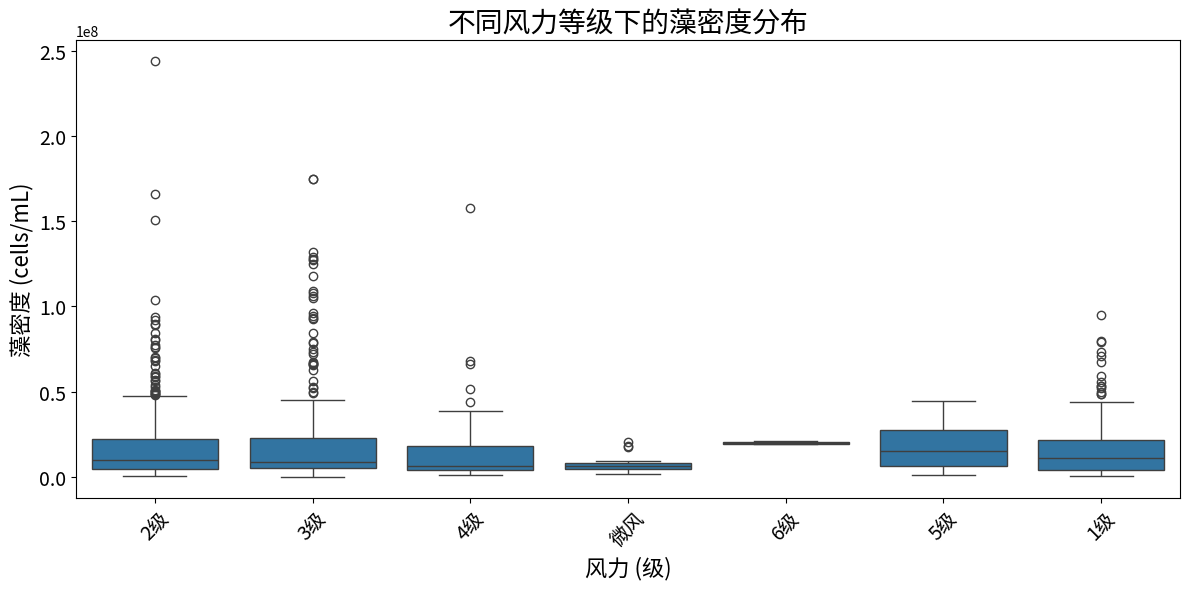

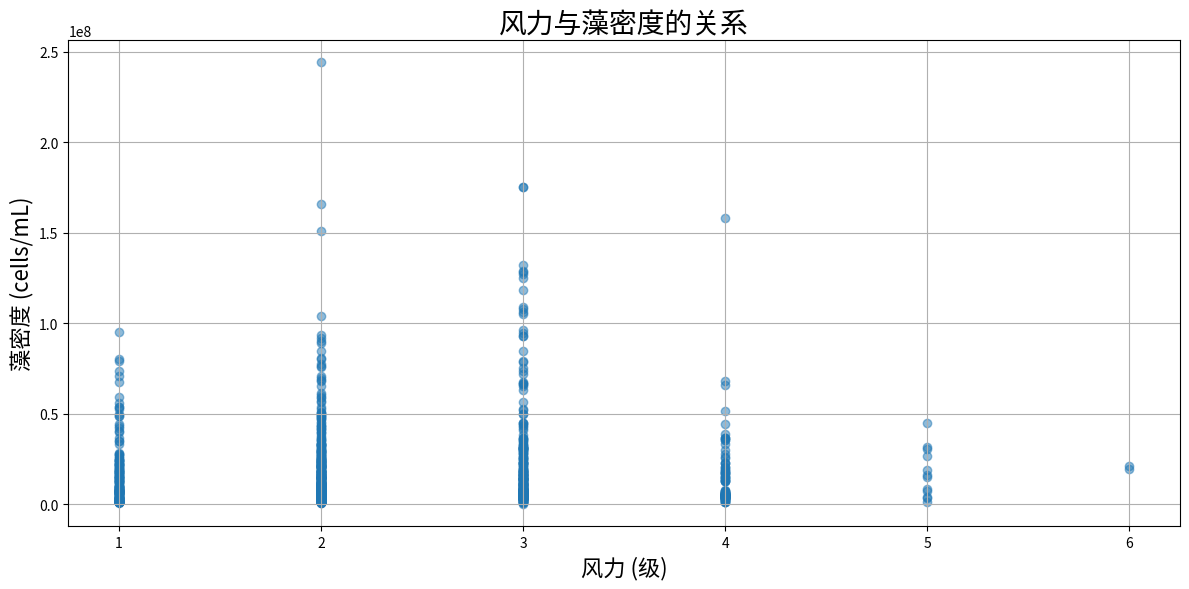


各风力阈值的统计分析:
--------------------------------------------------

风力2级阈值:
阈值以下均值: 15780252.89
阈值以上均值: 18082803.26
阈值以下样本量: 222
阈值以上样本量: 1086
p值: 0.219

风力3级阈值:
阈值以下均值: 17049745.20
阈值以上均值: 18618461.48
阈值以下样本量: 781
阈值以上样本量: 527
p值: 0.270

风力4级阈值:
阈值以下均值: 18018794.88
阈值以上均值: 14891466.81
阈值以下样本量: 1180
阈值以上样本量: 128
p值: 0.175

风力5级阈值:
阈值以下均值: 17698847.81
阈值以上均值: 17549834.29
阈值以下样本量: 1293
阈值以上样本量: 15
p值: 0.981

风力6级阈值:
阈值以下均值: 17692836.41
阈值以上均值: 19950000.00
阈值以下样本量: 1306
阈值以上样本量: 2
p值: 0.891


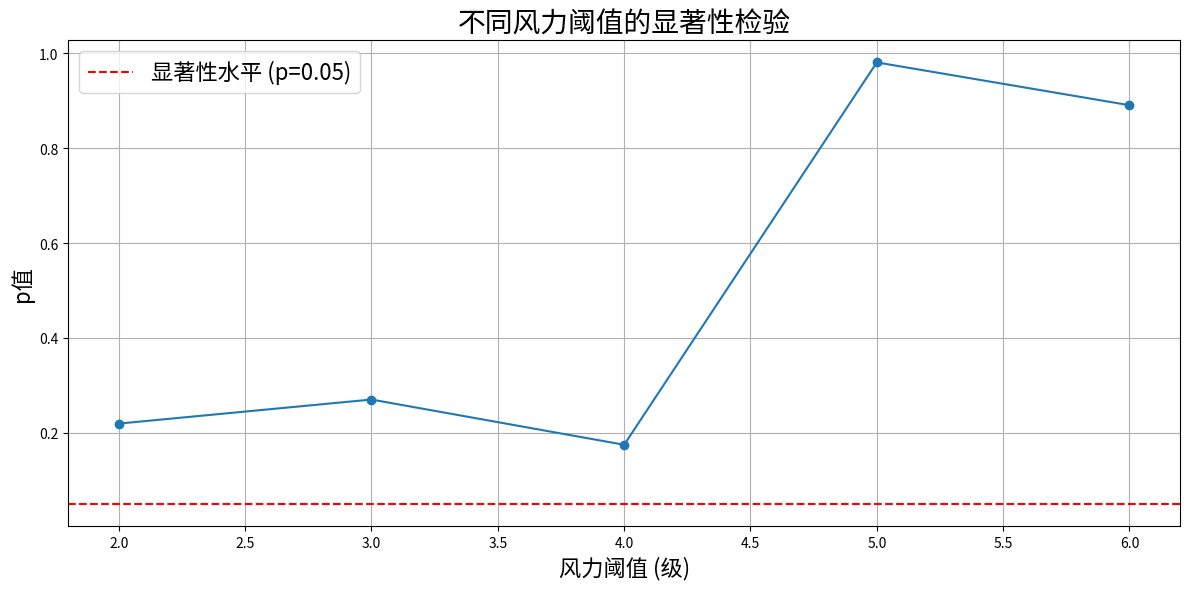

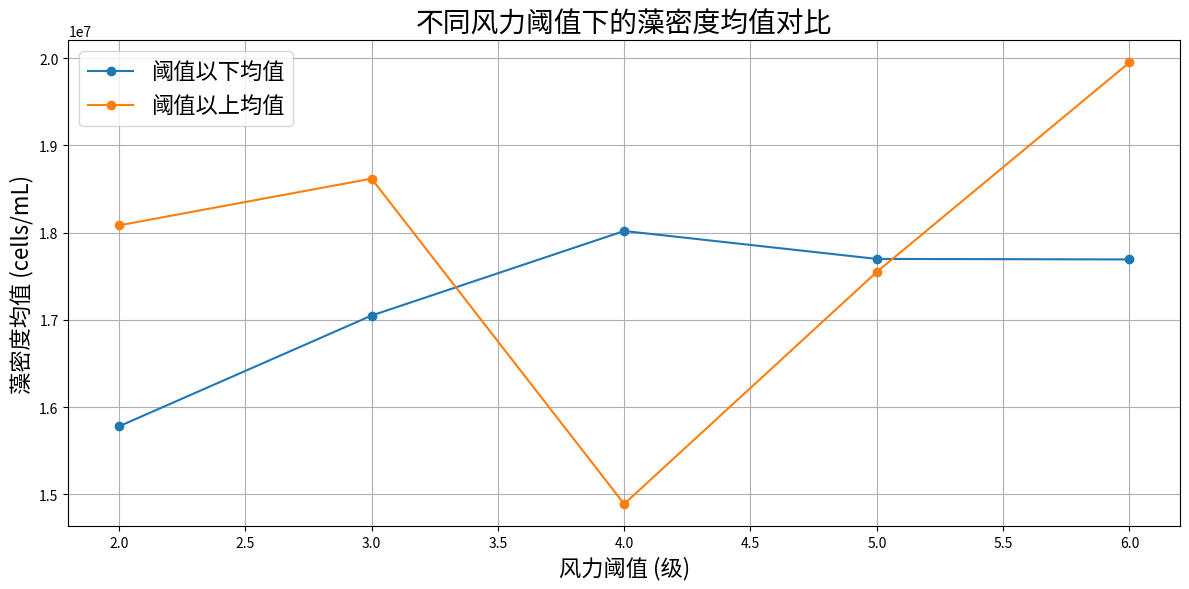

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


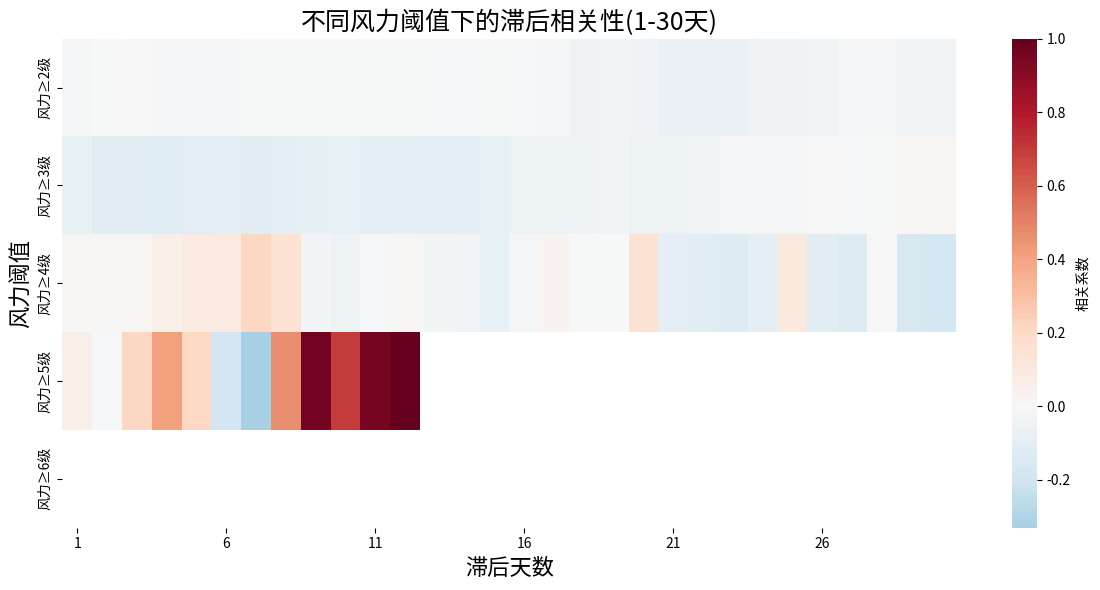

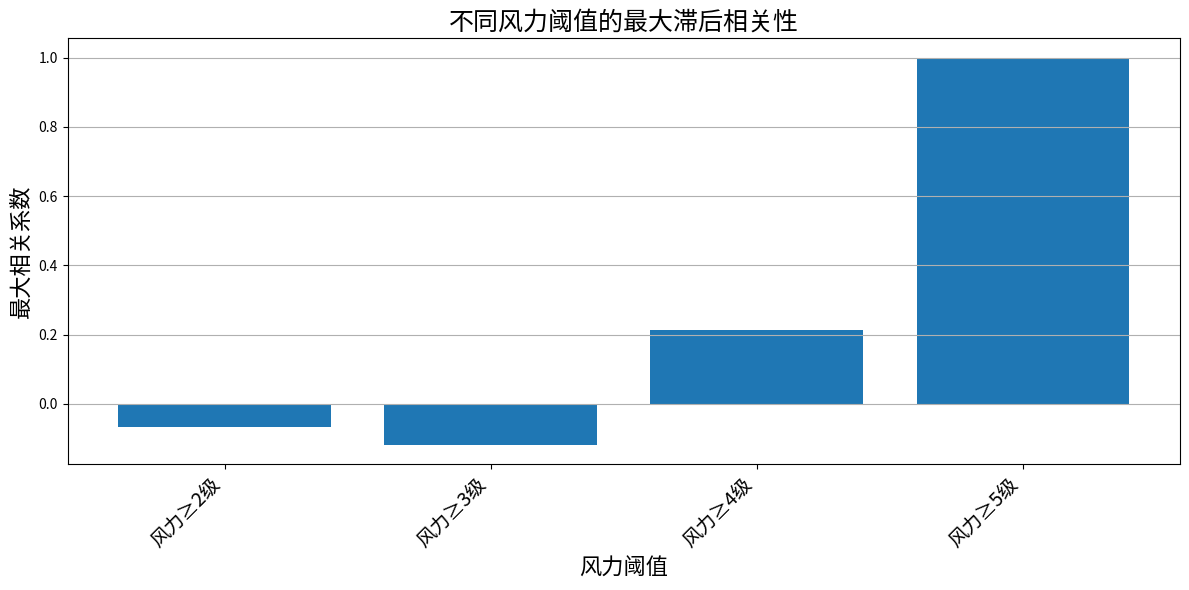


各风力阈值的最大滞后相关性及对应滞后天数:
风力≥2级: 相关系数 = -0.067, 滞后天数 = 21
风力≥3级: 相关系数 = -0.118, 滞后天数 = 4
风力≥4级: 相关系数 = 0.213, 滞后天数 = 7
风力≥5级: 相关系数 = 1.000, 滞后天数 = 12
风力≥6级: 相关系数 = nan, 滞后天数 = 1

各风力阈值下具有显著性差异的滞后天数:
风力≥2级: []
风力≥3级: []
风力≥4级: []
风力≥5级: []
风力≥6级: []


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import stats

# 设置中英文字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['axes.unicode_minus'] = False

chinese_font = fm.FontProperties(family='Noto Sans CJK JP', size=16)
english_font = fm.FontProperties(family='DejaVu Serif', size=16)

# 读取数据
# merged_df = pd.read_csv('003-气象-lanshanzui-merged.csv')

# 将风力转换为数值型,处理"微风"的情况
merged_df['wind_power_num'] = merged_df['wind_power'].map(lambda x: 1 if x == '微风' else float(x.replace('级','')))

# 分析不同风力阈值对藻密度的影响
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='wind_power', y='density')
plt.title('不同风力等级下的藻密度分布', fontproperties=chinese_font, fontsize=20)
plt.xlabel('风力 (级)', fontproperties=chinese_font, fontsize=16)
plt.ylabel('藻密度 (cells/mL)', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# 绘制风力与藻密度的散点图
plt.figure(figsize=(12, 6))
plt.scatter(merged_df['wind_power_num'], merged_df['density'], alpha=0.5)
plt.title('风力与藻密度的关系', fontproperties=chinese_font, fontsize=20)
plt.xlabel('风力 (级)', fontproperties=chinese_font, fontsize=16)
plt.ylabel('藻密度 (cells/mL)', fontproperties=chinese_font, fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# 统计分析各风力阈值的效应
print("\n各风力阈值的统计分析:")
print("-" * 50)

# 存储各阈值的统计结果
threshold_stats = []
max_wind_level = int(merged_df['wind_power_num'].max())

for threshold in range(2, max_wind_level + 1):
    below_threshold = merged_df[merged_df['wind_power_num'] < threshold]['density']
    above_threshold = merged_df[merged_df['wind_power_num'] >= threshold]['density']
    
    t_stat, p_value = stats.ttest_ind(below_threshold.dropna(), above_threshold.dropna())
    
    threshold_stats.append({
        '阈值': threshold,
        '阈值以下均值': below_threshold.mean(),
        '阈值以上均值': above_threshold.mean(),
        'p值': p_value,
        '样本量差异': len(below_threshold) - len(above_threshold)
    })
    
    print(f"\n风力{threshold}级阈值:")
    print(f"阈值以下均值: {below_threshold.mean():.2f}")
    print(f"阈值以上均值: {above_threshold.mean():.2f}")
    print(f"阈值以下样本量: {len(below_threshold)}")
    print(f"阈值以上样本量: {len(above_threshold)}")
    print(f"p值: {p_value:.3f}")

# 绘制不同阈值的p值变化
threshold_df = pd.DataFrame(threshold_stats)
plt.figure(figsize=(12, 6))
plt.plot(threshold_df['阈值'], threshold_df['p值'], marker='o')
plt.axhline(y=0.05, color='r', linestyle='--', label='显著性水平 (p=0.05)')
plt.title('不同风力阈值的显著性检验', fontproperties=chinese_font, fontsize=20)
plt.xlabel('风力阈值 (级)', fontproperties=chinese_font, fontsize=16)
plt.ylabel('p值', fontproperties=chinese_font, fontsize=16)
plt.grid(True)
plt.legend(prop=chinese_font)
plt.tight_layout()
plt.show()

# 绘制阈值前后的藻密度均值对比
plt.figure(figsize=(12, 6))
plt.plot(threshold_df['阈值'], threshold_df['阈值以下均值'], label='阈值以下均值', marker='o')
plt.plot(threshold_df['阈值'], threshold_df['阈值以上均值'], label='阈值以上均值', marker='o')
plt.title('不同风力阈值下的藻密度均值对比', fontproperties=chinese_font, fontsize=20)
plt.xlabel('风力阈值 (级)', fontproperties=chinese_font, fontsize=16)
plt.ylabel('藻密度均值 (cells/mL)', fontproperties=chinese_font, fontsize=16)
plt.grid(True)
plt.legend(prop=chinese_font)
plt.tight_layout()
plt.show()



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import stats

# 计算不同风力阈值下的滞后相关性
max_lag = 30  # 最大滞后天数
thresholds = range(2, int(merged_df['wind_power_num'].max()) + 1)

# 存储每个阈值的滞后相关性
threshold_lag_correlations = {}

for threshold in thresholds:
    lag_corrs = []
    for lag in range(1, max_lag + 1):
        # 计算风力大于等于阈值的情况下的滞后相关性
        above_threshold = merged_df[merged_df['wind_power_num'] >= threshold]
        lagged_corr = above_threshold['wind_power_num'].shift(lag).corr(above_threshold['density'])
        lag_corrs.append(lagged_corr)
    threshold_lag_correlations[f'风力≥{threshold}级'] = lag_corrs

# 绘制滞后相关性热力图
plt.figure(figsize=(12, 6))
lag_data = pd.DataFrame(threshold_lag_correlations, index=range(1, max_lag + 1))
sns.heatmap(lag_data.T, cmap='RdBu_r', center=0,
            xticklabels=5,
            cbar_kws={'label': '相关系数'})
plt.title('不同风力阈值下的滞后相关性(1-30天)', fontproperties=chinese_font, fontsize=18)
plt.xlabel('滞后天数', fontproperties=chinese_font, fontsize=16)
plt.ylabel('风力阈值', fontproperties=chinese_font, fontsize=16)
plt.tight_layout()
plt.show()

# 找出每个阈值的最大滞后相关性
max_lag_correlations = {}
for threshold, lag_corrs in threshold_lag_correlations.items():
    max_corr = max(lag_corrs, key=abs)
    max_lag = lag_corrs.index(max_corr) + 1
    max_lag_correlations[threshold] = (max_corr, max_lag)

# 绘制最大滞后相关性柱状图
plt.figure(figsize=(12, 6))
max_corrs = [corr for corr, _ in max_lag_correlations.values()]
plt.bar(max_lag_correlations.keys(), max_corrs)
plt.title('不同风力阈值的最大滞后相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('风力阈值', fontproperties=chinese_font, fontsize=16)
plt.ylabel('最大相关系数', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 输出每个阈值的最大滞后相关性及对应滞后天数
print("\n各风力阈值的最大滞后相关性及对应滞后天数:")
for threshold, (corr, lag) in max_lag_correlations.items():
    print(f"{threshold}: 相关系数 = {corr:.3f}, 滞后天数 = {lag}")

# 分析不同滞后天数下的统计显著性
significant_lags = {}
for threshold in thresholds:
    significant_days = []
    for lag in range(1, max_lag + 1):
        above_threshold = merged_df[merged_df['wind_power_num'] >= threshold]
        below_threshold = merged_df[merged_df['wind_power_num'] < threshold]
        
        # 计算滞后后的藻密度差异显著性
        t_stat, p_value = stats.ttest_ind(
            above_threshold['density'].shift(lag).dropna(),
            below_threshold['density'].shift(lag).dropna()
        )
        if p_value < 0.05:
            significant_days.append(lag)
    significant_lags[f'风力≥{threshold}级'] = significant_days

# 输出显著性分析结果
print("\n各风力阈值下具有显著性差异的滞后天数:")
for threshold, days in significant_lags.items():
    print(f"{threshold}: {days}")

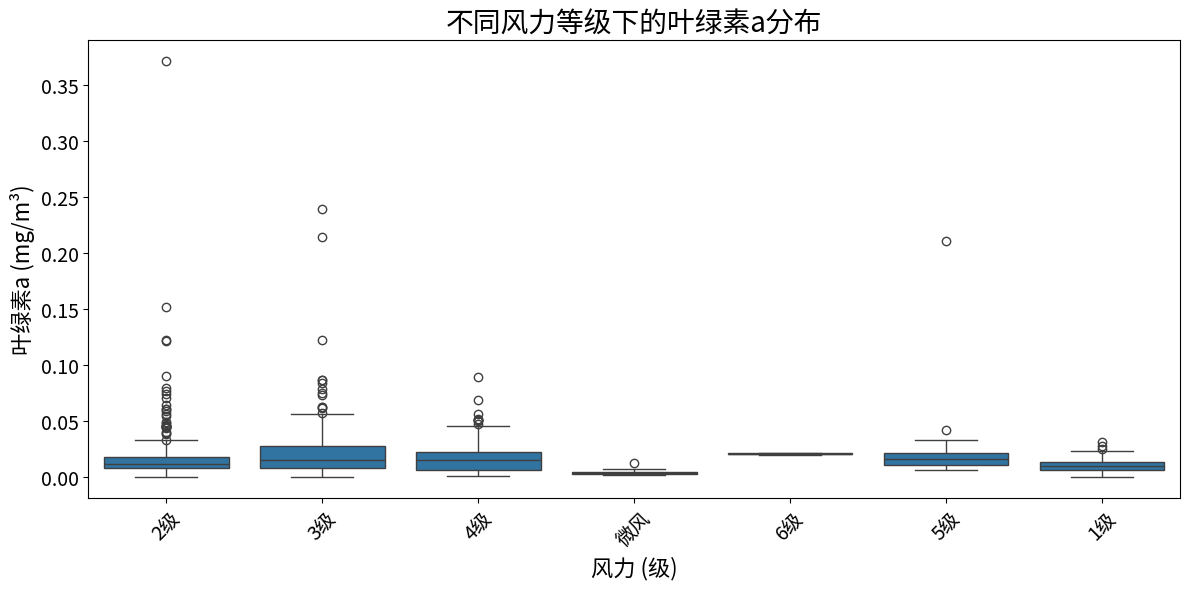

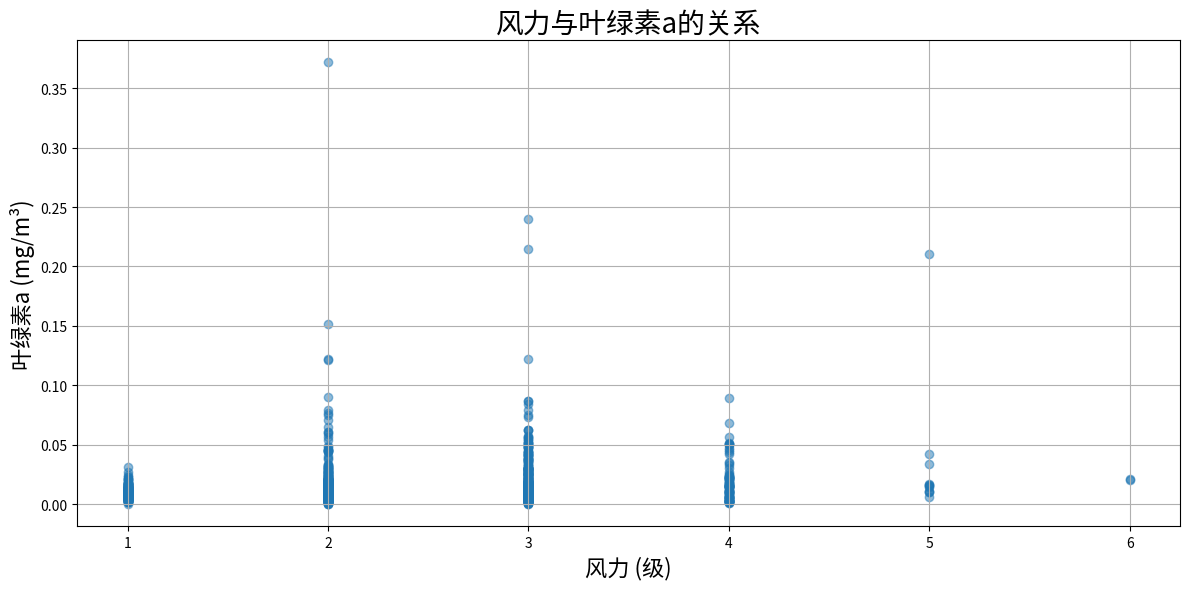


各风力阈值的统计分析:
--------------------------------------------------

风力2级阈值:
阈值以下均值: 0.01
阈值以上均值: 0.02
阈值以下样本量: 222
阈值以上样本量: 1086
p值: 0.000

风力3级阈值:
阈值以下均值: 0.01
阈值以上均值: 0.02
阈值以下样本量: 781
阈值以上样本量: 527
p值: 0.000

风力4级阈值:
阈值以下均值: 0.02
阈值以上均值: 0.02
阈值以下样本量: 1180
阈值以上样本量: 128
p值: 0.171

风力5级阈值:
阈值以下均值: 0.02
阈值以上均值: 0.03
阈值以下样本量: 1293
阈值以上样本量: 15
p值: 0.010

风力6级阈值:
阈值以下均值: 0.02
阈值以上均值: 0.02
阈值以下样本量: 1306
阈值以上样本量: 2
p值: 0.810


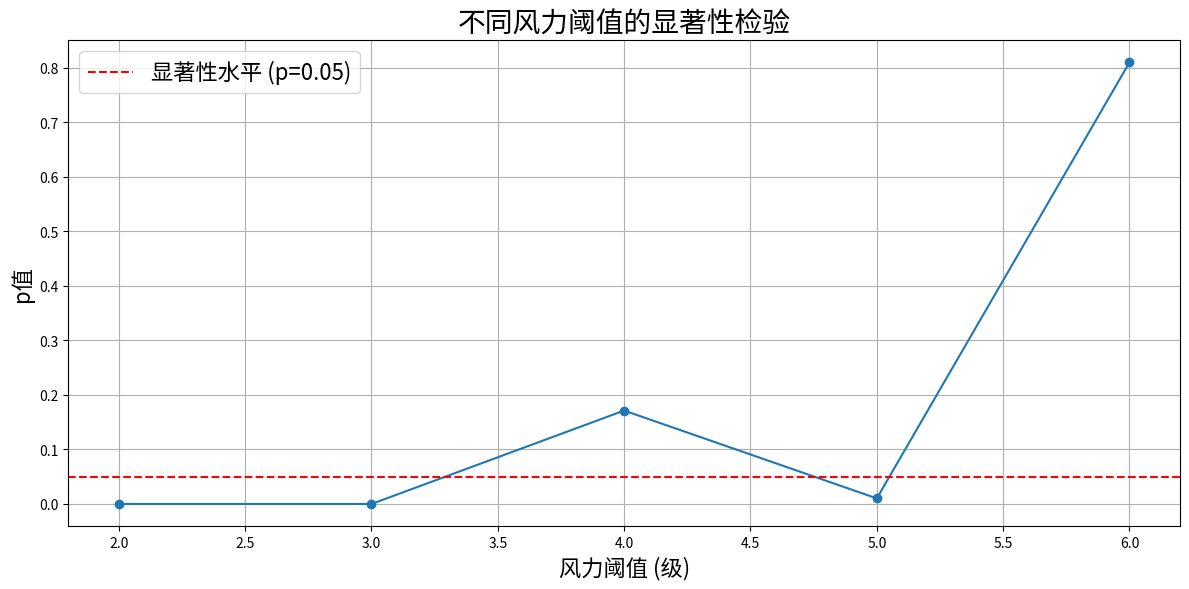

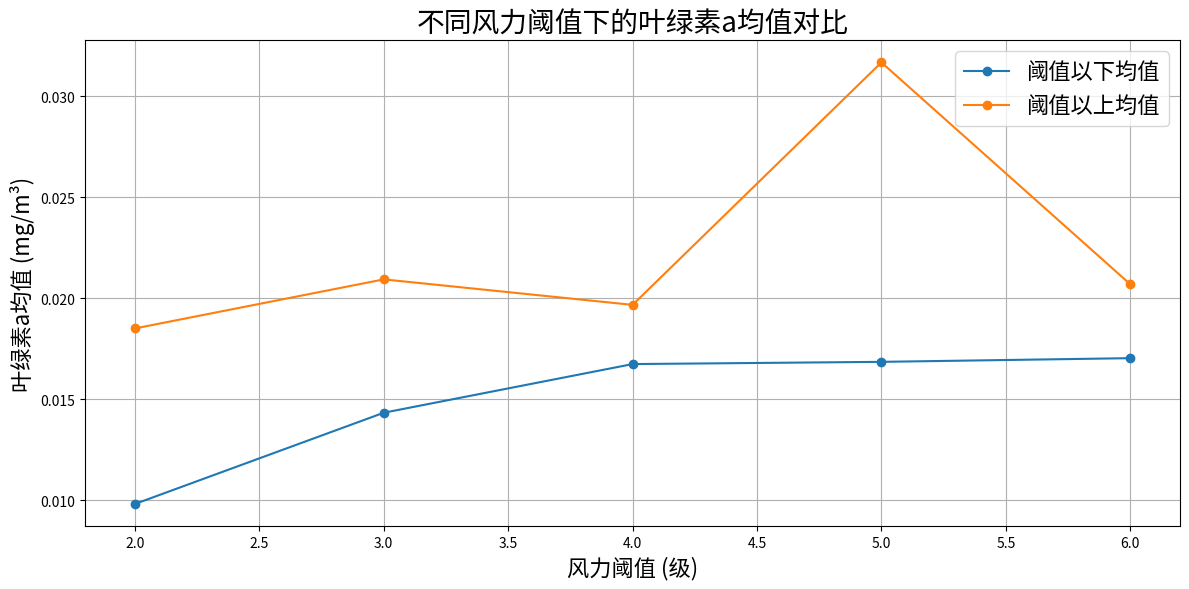

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


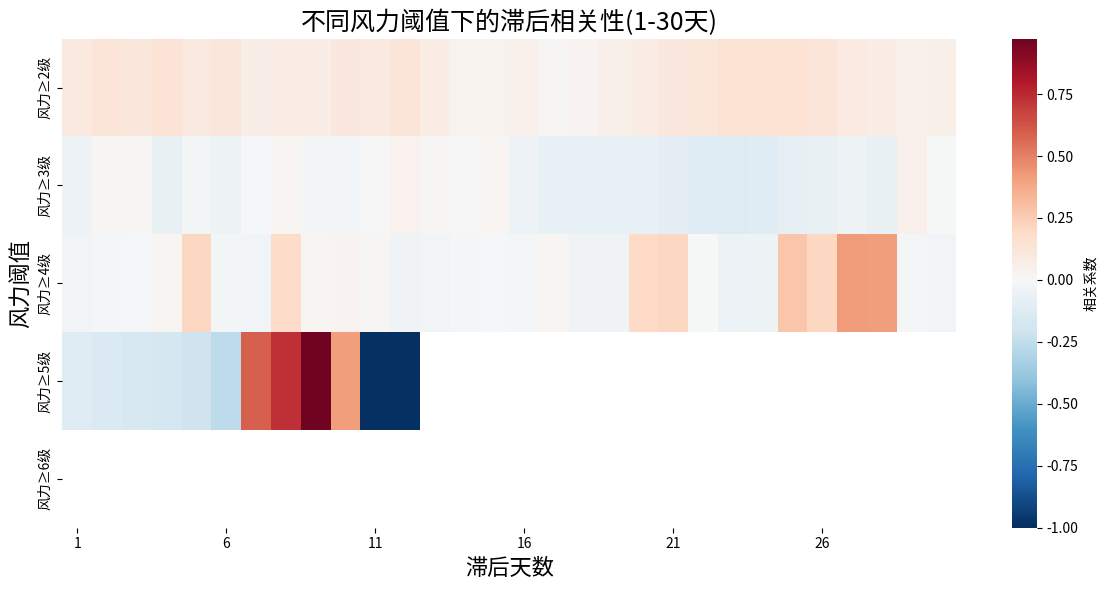

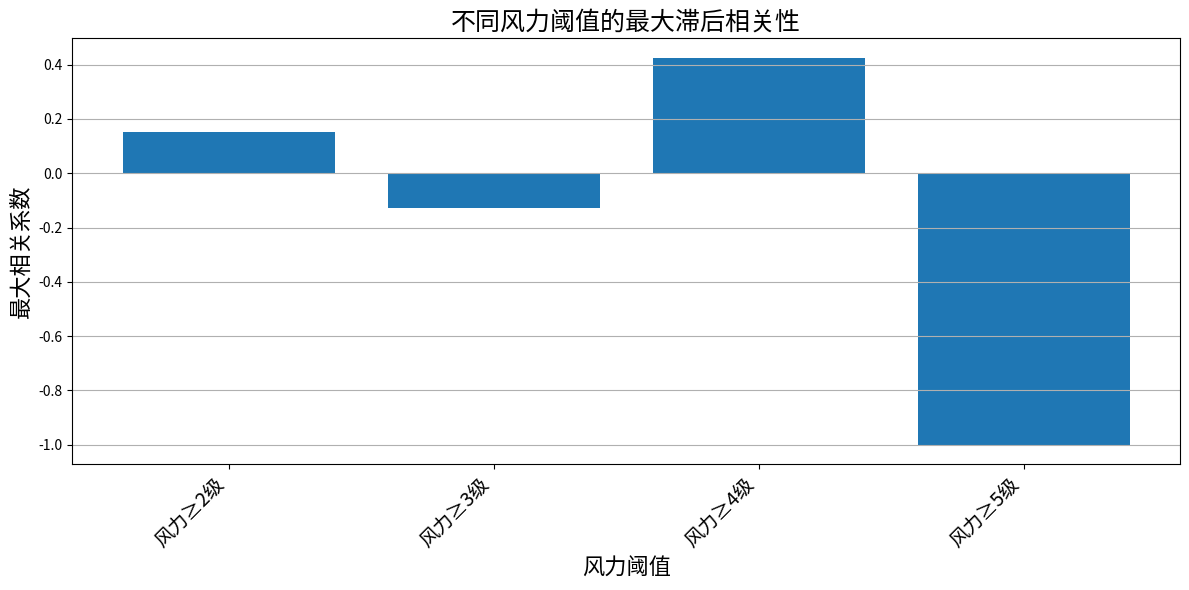


各风力阈值的最大滞后相关性及对应滞后天数:
风力≥2级: 相关系数 = 0.152, 滞后天数 = 25
风力≥3级: 相关系数 = -0.129, 滞后天数 = 23
风力≥4级: 相关系数 = 0.426, 滞后天数 = 27
风力≥5级: 相关系数 = -1.000, 滞后天数 = 12
风力≥6级: 相关系数 = nan, 滞后天数 = 1

各风力阈值下具有显著性差异的滞后天数:
风力≥2级: [1]
风力≥3级: [1]
风力≥4级: []
风力≥5级: [1]
风力≥6级: []


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import stats

# 设置中英文字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['axes.unicode_minus'] = False

chinese_font = fm.FontProperties(family='Noto Sans CJK JP', size=16)
english_font = fm.FontProperties(family='DejaVu Serif', size=16)

# # 读取数据
# merged_df = pd.read_csv('003-气象-lanshanzui-merged.csv')

# 将风力转换为数值型,处理"微风"的情况
merged_df['wind_power_num'] = merged_df['wind_power'].map(lambda x: 1 if x == '微风' else float(x.replace('级','')))

# 分析不同风力阈值对叶绿素a的影响
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='wind_power', y='chla')
plt.title('不同风力等级下的叶绿素a分布', fontproperties=chinese_font, fontsize=20)
plt.xlabel('风力 (级)', fontproperties=chinese_font, fontsize=16)
plt.ylabel('叶绿素a (mg/m³)', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# 绘制风力与叶绿素a的散点图
plt.figure(figsize=(12, 6))
plt.scatter(merged_df['wind_power_num'], merged_df['chla'], alpha=0.5)
plt.title('风力与叶绿素a的关系', fontproperties=chinese_font, fontsize=20)
plt.xlabel('风力 (级)', fontproperties=chinese_font, fontsize=16)
plt.ylabel('叶绿素a (mg/m³)', fontproperties=chinese_font, fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# 统计分析各风力阈值的效应
print("\n各风力阈值的统计分析:")
print("-" * 50)

# 存储各阈值的统计结果
threshold_stats = []
max_wind_level = int(merged_df['wind_power_num'].max())

for threshold in range(2, max_wind_level + 1):
    below_threshold = merged_df[merged_df['wind_power_num'] < threshold]['chla']
    above_threshold = merged_df[merged_df['wind_power_num'] >= threshold]['chla']
    
    t_stat, p_value = stats.ttest_ind(below_threshold.dropna(), above_threshold.dropna())
    
    threshold_stats.append({
        '阈值': threshold,
        '阈值以下均值': below_threshold.mean(),
        '阈值以上均值': above_threshold.mean(),
        'p值': p_value,
        '样本量差异': len(below_threshold) - len(above_threshold)
    })
    
    print(f"\n风力{threshold}级阈值:")
    print(f"阈值以下均值: {below_threshold.mean():.2f}")
    print(f"阈值以上均值: {above_threshold.mean():.2f}")
    print(f"阈值以下样本量: {len(below_threshold)}")
    print(f"阈值以上样本量: {len(above_threshold)}")
    print(f"p值: {p_value:.3f}")

# 绘制不同阈值的p值变化
threshold_df = pd.DataFrame(threshold_stats)
plt.figure(figsize=(12, 6))
plt.plot(threshold_df['阈值'], threshold_df['p值'], marker='o')
plt.axhline(y=0.05, color='r', linestyle='--', label='显著性水平 (p=0.05)')
plt.title('不同风力阈值的显著性检验', fontproperties=chinese_font, fontsize=20)
plt.xlabel('风力阈值 (级)', fontproperties=chinese_font, fontsize=16)
plt.ylabel('p值', fontproperties=chinese_font, fontsize=16)
plt.grid(True)
plt.legend(prop=chinese_font)
plt.tight_layout()
plt.show()

# 绘制阈值前后的叶绿素a均值对比
plt.figure(figsize=(12, 6))
plt.plot(threshold_df['阈值'], threshold_df['阈值以下均值'], label='阈值以下均值', marker='o')
plt.plot(threshold_df['阈值'], threshold_df['阈值以上均值'], label='阈值以上均值', marker='o')
plt.title('不同风力阈值下的叶绿素a均值对比', fontproperties=chinese_font, fontsize=20)
plt.xlabel('风力阈值 (级)', fontproperties=chinese_font, fontsize=16)
plt.ylabel('叶绿素a均值 (mg/m³)', fontproperties=chinese_font, fontsize=16)
plt.grid(True)
plt.legend(prop=chinese_font)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import stats

# 计算不同风力阈值下的滞后相关性
max_lag = 30  # 最大滞后天数
thresholds = range(2, int(merged_df['wind_power_num'].max()) + 1)

# 存储每个阈值的滞后相关性
threshold_lag_correlations = {}

for threshold in thresholds:
    lag_corrs = []
    for lag in range(1, max_lag + 1):
        # 计算风力大于等于阈值的情况下的滞后相关性
        above_threshold = merged_df[merged_df['wind_power_num'] >= threshold]
        lagged_corr = above_threshold['wind_power_num'].shift(lag).corr(above_threshold['chla'])
        lag_corrs.append(lagged_corr)
    threshold_lag_correlations[f'风力≥{threshold}级'] = lag_corrs

# 绘制滞后相关性热力图
plt.figure(figsize=(12, 6))
lag_data = pd.DataFrame(threshold_lag_correlations, index=range(1, max_lag + 1))
sns.heatmap(lag_data.T, cmap='RdBu_r', center=0,
            xticklabels=5,
            cbar_kws={'label': '相关系数'})
plt.title('不同风力阈值下的滞后相关性(1-30天)', fontproperties=chinese_font, fontsize=18)
plt.xlabel('滞后天数', fontproperties=chinese_font, fontsize=16)
plt.ylabel('风力阈值', fontproperties=chinese_font, fontsize=16)
plt.tight_layout()
plt.show()

# 找出每个阈值的最大滞后相关性
max_lag_correlations = {}
for threshold, lag_corrs in threshold_lag_correlations.items():
    max_corr = max(lag_corrs, key=abs)
    max_lag = lag_corrs.index(max_corr) + 1
    max_lag_correlations[threshold] = (max_corr, max_lag)

# 绘制最大滞后相关性柱状图
plt.figure(figsize=(12, 6))
max_corrs = [corr for corr, _ in max_lag_correlations.values()]
plt.bar(max_lag_correlations.keys(), max_corrs)
plt.title('不同风力阈值的最大滞后相关性', fontproperties=chinese_font, fontsize=18)
plt.xlabel('风力阈值', fontproperties=chinese_font, fontsize=16)
plt.ylabel('最大相关系数', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 输出每个阈值的最大滞后相关性及对应滞后天数
print("\n各风力阈值的最大滞后相关性及对应滞后天数:")
for threshold, (corr, lag) in max_lag_correlations.items():
    print(f"{threshold}: 相关系数 = {corr:.3f}, 滞后天数 = {lag}")

# 分析不同滞后天数下的统计显著性
significant_lags = {}
for threshold in thresholds:
    significant_days = []
    for lag in range(1, max_lag + 1):
        above_threshold = merged_df[merged_df['wind_power_num'] >= threshold]
        below_threshold = merged_df[merged_df['wind_power_num'] < threshold]
        
        # 计算滞后后的叶绿素a差异显著性
        t_stat, p_value = stats.ttest_ind(
            above_threshold['chla'].shift(lag).dropna(),
            below_threshold['chla'].shift(lag).dropna()
        )
        if p_value < 0.05:
            significant_days.append(lag)
    significant_lags[f'风力≥{threshold}级'] = significant_days

# 输出显著性分析结果
print("\n各风力阈值下具有显著性差异的滞后天数:")
for threshold, days in significant_lags.items():
    print(f"{threshold}: {days}")

/tmp/ipykernel_14025/414975794.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), ha='right')
/tmp/ipykernel_14025/414975794.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')


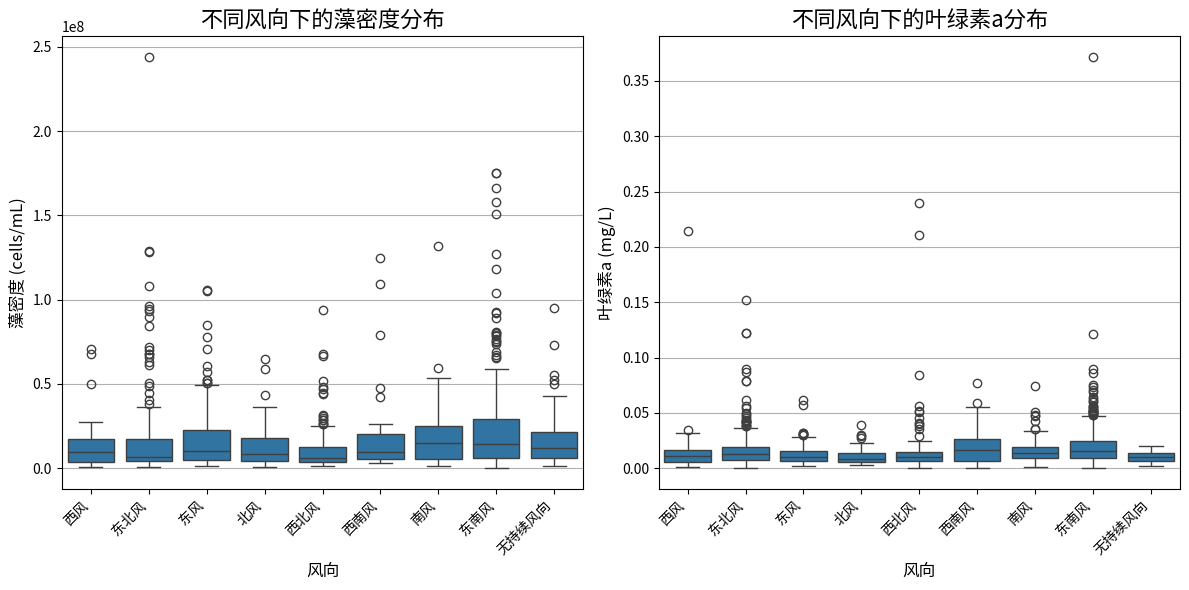


不同风向的平均藻密度和叶绿素a浓度:
东南风:
  藻密度: 23,166,981.39 cells/mL
  叶绿素a: 0.022 mg/L
南风:
  藻密度: 20,150,456.00 cells/mL
  叶绿素a: 0.018 mg/L
西南风:
  藻密度: 17,596,943.57 cells/mL
  叶绿素a: 0.020 mg/L
无持续风向:
  藻密度: 17,373,995.38 cells/mL
  叶绿素a: 0.011 mg/L
东风:
  藻密度: 16,910,640.54 cells/mL
  叶绿素a: 0.012 mg/L
东北风:
  藻密度: 16,361,259.00 cells/mL
  叶绿素a: 0.018 mg/L
西风:
  藻密度: 13,538,261.82 cells/mL
  叶绿素a: 0.016 mg/L
北风:
  藻密度: 13,334,770.24 cells/mL
  叶绿素a: 0.011 mg/L
西北风:
  藻密度: 11,559,429.77 cells/mL
  叶绿素a: 0.016 mg/L

风向影响的方差分析结果:
藻密度:
  F统计量: nan
  P值: nan
  风向对藻密度无显著影响 (p >= 0.05)

叶绿素a:
  F统计量: nan
  P值: nan
  风向对叶绿素a无显著影响 (p >= 0.05)


/tmp/ipykernel_14025/414975794.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), ha='right')
/tmp/ipykernel_14025/414975794.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')


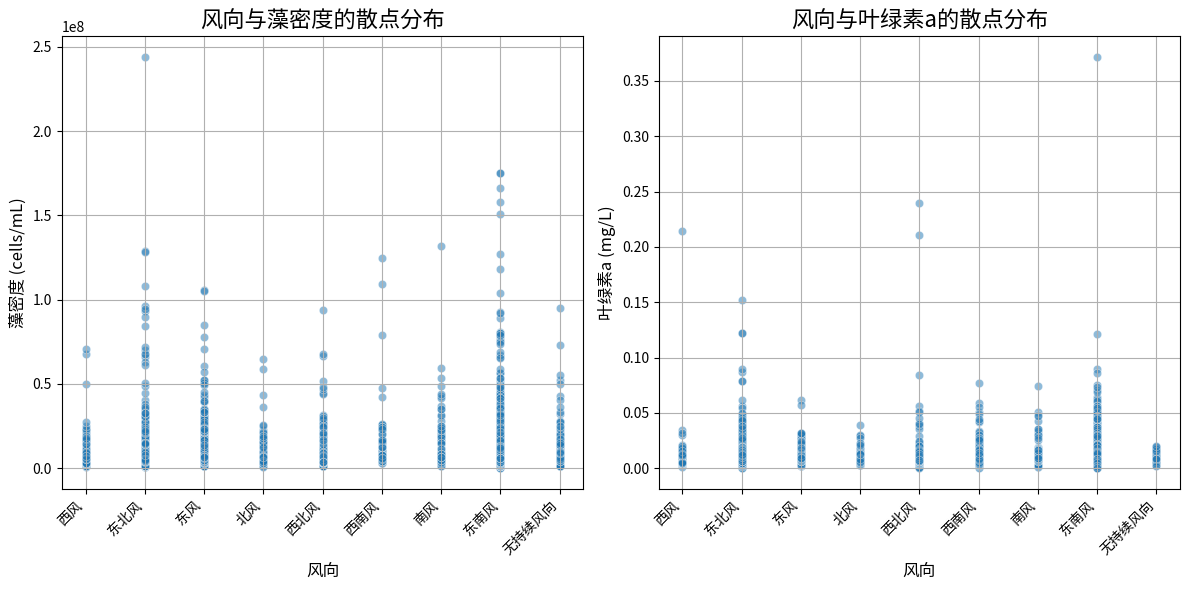

In [4]:
# 分析不同风向对藻密度和叶绿素a的影响
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 藻密度箱线图
sns.boxplot(data=merged_df, x='wind_direction', y='density', ax=ax1)
ax1.set_title('不同风向下的藻密度分布', fontproperties=chinese_font, fontsize=16)
ax1.set_xlabel('风向', fontproperties=chinese_font, fontsize=12)
ax1.set_ylabel('藻密度 (cells/mL)', fontproperties=chinese_font, fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.set_xticklabels(ax1.get_xticklabels(), ha='right')
ax1.grid(True, axis='y')

# 叶绿素a箱线图
sns.boxplot(data=merged_df, x='wind_direction', y='chla', ax=ax2)
ax2.set_title('不同风向下的叶绿素a分布', fontproperties=chinese_font, fontsize=16)
ax2.set_xlabel('风向', fontproperties=chinese_font, fontsize=12)
ax2.set_ylabel('叶绿素a (mg/L)', fontproperties=chinese_font, fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')
ax2.grid(True, axis='y')

plt.tight_layout()
plt.show()

# 计算不同风向的平均藻密度和叶绿素a
wind_dir_stats = merged_df.groupby('wind_direction').agg({
    'density': 'mean',
    'chla': 'mean'
}).sort_values('density', ascending=False)

print("\n不同风向的平均藻密度和叶绿素a浓度:")
for wind_dir in wind_dir_stats.index:
    print(f"{wind_dir}:")
    print(f"  藻密度: {wind_dir_stats.loc[wind_dir, 'density']:,.2f} cells/mL")
    print(f"  叶绿素a: {wind_dir_stats.loc[wind_dir, 'chla']:.3f} mg/L")

# 进行单因素方差分析(ANOVA)检验风向的影响
# 对藻密度的影响
density_groups = [group['density'].values for name, group in merged_df.groupby('wind_direction')]
f_stat_density, p_value_density = stats.f_oneway(*density_groups)

# 对叶绿素a的影响
chla_groups = [group['chla'].values for name, group in merged_df.groupby('wind_direction')]
f_stat_chla, p_value_chla = stats.f_oneway(*chla_groups)

print(f"\n风向影响的方差分析结果:")
print(f"藻密度:")
print(f"  F统计量: {f_stat_density:.3f}")
print(f"  P值: {p_value_density:.3f}")
if p_value_density < 0.05:
    print("  风向对藻密度有显著影响 (p < 0.05)")
else:
    print("  风向对藻密度无显著影响 (p >= 0.05)")

print(f"\n叶绿素a:")
print(f"  F统计量: {f_stat_chla:.3f}")
print(f"  P值: {p_value_chla:.3f}")
if p_value_chla < 0.05:
    print("  风向对叶绿素a有显著影响 (p < 0.05)")
else:
    print("  风向对叶绿素a无显著影响 (p >= 0.05)")

# 绘制风向与藻密度、叶绿素a的散点图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=merged_df, x='wind_direction', y='density', alpha=0.5, ax=ax1)
ax1.set_title('风向与藻密度的散点分布', fontproperties=chinese_font, fontsize=16)
ax1.set_xlabel('风向', fontproperties=chinese_font, fontsize=12)
ax1.set_ylabel('藻密度 (cells/mL)', fontproperties=chinese_font, fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.set_xticklabels(ax1.get_xticklabels(), ha='right')
ax1.grid(True)

sns.scatterplot(data=merged_df, x='wind_direction', y='chla', alpha=0.5, ax=ax2)
ax2.set_title('风向与叶绿素a的散点分布', fontproperties=chinese_font, fontsize=16)
ax2.set_xlabel('风向', fontproperties=chinese_font, fontsize=12)
ax2.set_ylabel('叶绿素a (mg/L)', fontproperties=chinese_font, fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')
ax2.grid(True)

plt.tight_layout()
plt.show()



天气与藻密度的相关性:
density        1.000000
weather_多云     0.164229
weather_雨      0.041946
weather_大雨     0.037516
weather_中雨     0.019700
weather_雷阵雨   -0.001778
weather_浮尘    -0.003642
weather_阵雨    -0.010560
weather_暴雨    -0.012822
weather_扬沙    -0.013858
weather_小雪    -0.015006
weather_雪     -0.022845
weather_小雨    -0.035169
weather_阴     -0.038288
weather_雨夹雪   -0.055972
weather_雾     -0.080846
weather_晴     -0.093040
weather_霾     -0.101082
Name: density, dtype: float64

天气与叶绿素a的相关性:
chla           1.000000
weather_多云     0.220225
weather_大雨     0.061160
weather_小雪     0.044570
weather_中雨     0.031183
weather_暴雨     0.022841
weather_雨夹雪   -0.000974
weather_浮尘    -0.003699
weather_扬沙    -0.017778
weather_雪     -0.018735
weather_雷阵雨   -0.018816
weather_小雨    -0.025672
weather_雨     -0.029118
weather_阵雨    -0.029154
weather_霾     -0.047095
weather_雾     -0.067061
weather_阴     -0.133917
weather_晴     -0.188598
Name: chla, dtype: float64


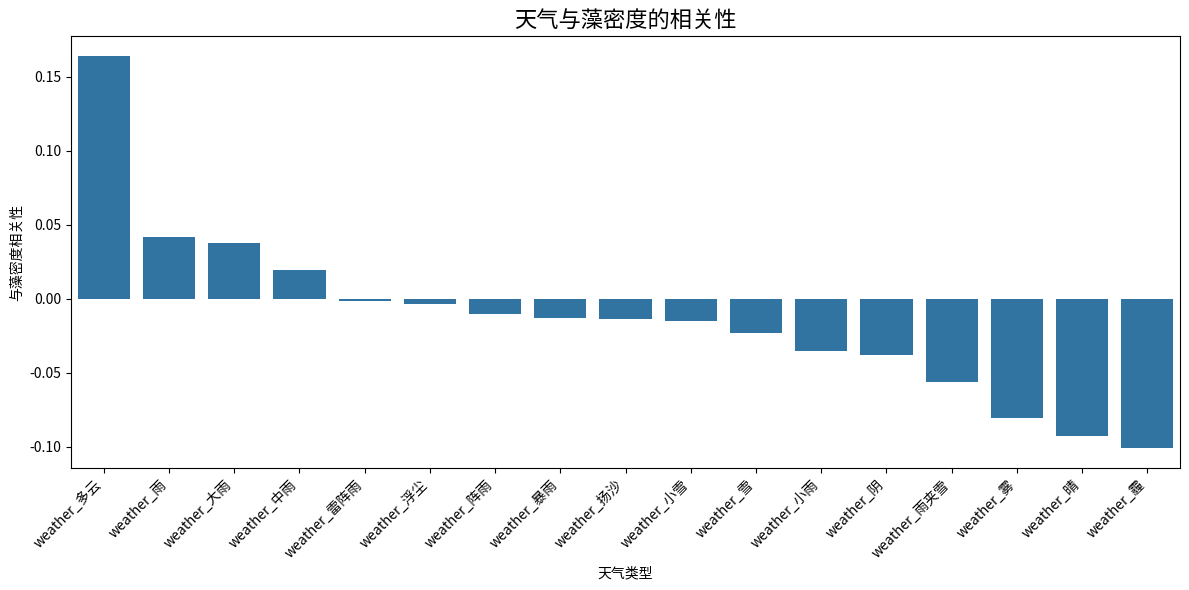

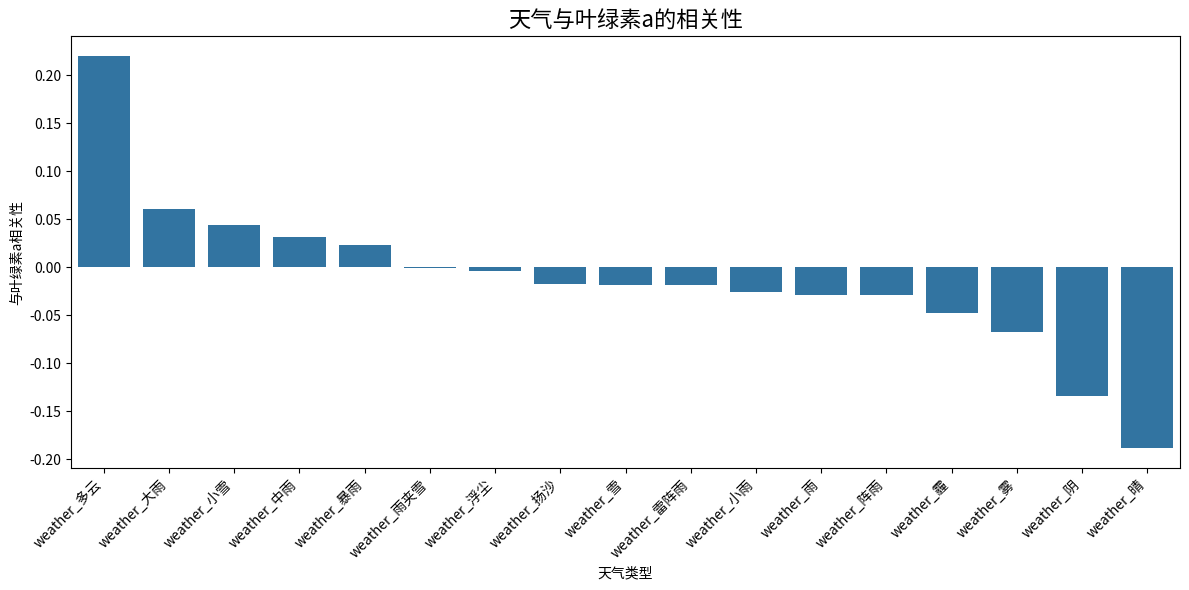

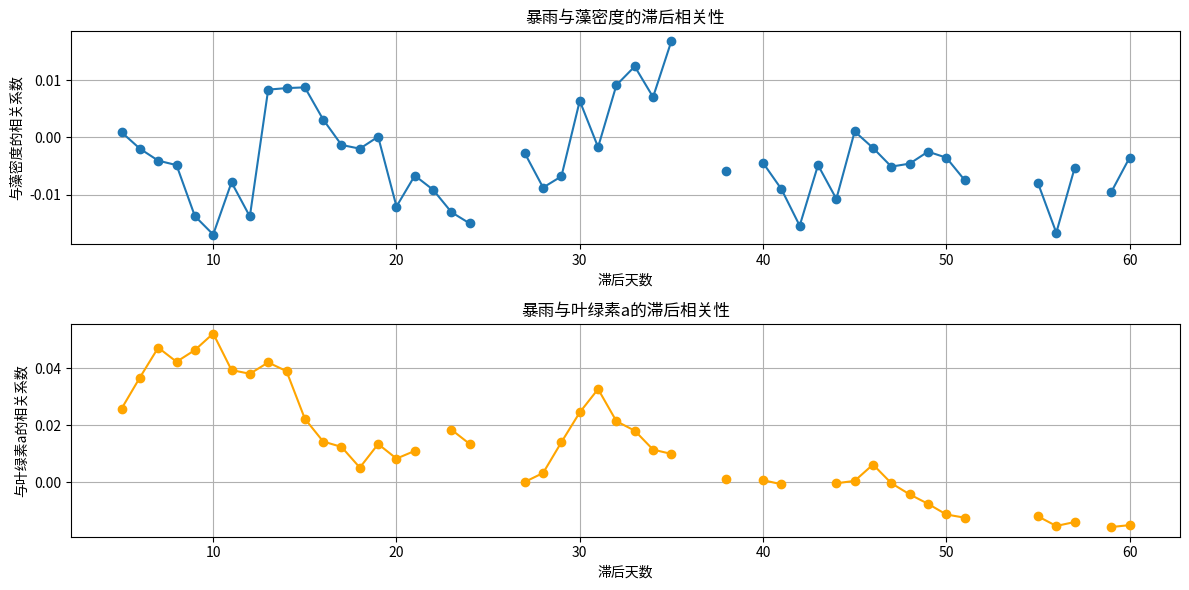


暴雨对藻密度的最大相关性出现在滞后1天，相关系数为nan
暴雨对叶绿素a的最大相关性出现在滞后1天，相关系数为nan

对藻密度最优的温度阈值为11度，最大相关系数为0.261
对叶绿素a最优的温度阈值为33度，最大相关系数为0.039


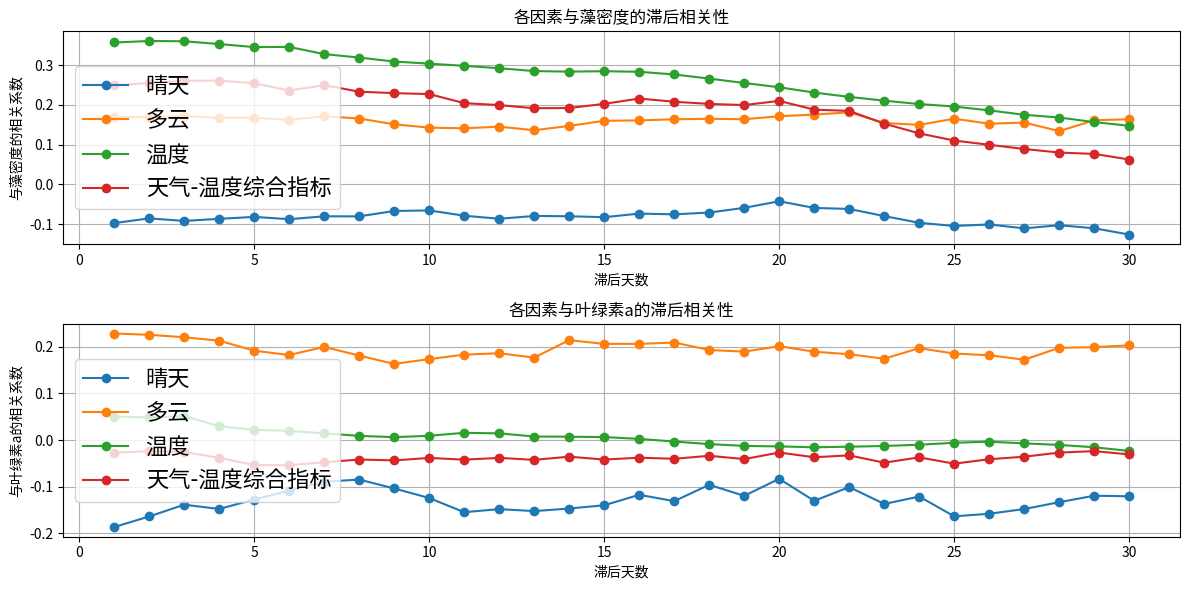


各因素与藻密度的最大相关性：
weather_晴的最大相关性出现在滞后20天，相关系数为-0.042
weather_多云的最大相关性出现在滞后22天，相关系数为0.182
temperature的最大相关性出现在滞后2天，相关系数为0.361
weather_temp_index的最大相关性出现在滞后4天，相关系数为0.261

各因素与叶绿素a的最大相关性：
weather_晴的最大相关性出现在滞后20天，相关系数为-0.083
weather_多云的最大相关性出现在滞后1天，相关系数为0.228
temperature的最大相关性出现在滞后3天，相关系数为0.052
weather_temp_index的最大相关性出现在滞后29天，相关系数为-0.024


In [5]:
# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

all_weather_types = set()
for weather in merged_df['weather'].dropna():
    all_weather_types.update(split_weather(weather))

for weather_type in all_weather_types:
    merged_df[f'weather_{weather_type}'] = merged_df['weather'].apply(lambda x: 1 if pd.notna(x) and weather_type in split_weather(x) else 0)

# 计算天气与藻密度、叶绿素a的相关性
weather_columns = [col for col in merged_df.columns if col.startswith('weather_')]

# 计算相关系数
corr_density = merged_df[weather_columns + ['density']].corr()['density'].sort_values(ascending=False)
corr_chla = merged_df[weather_columns + ['chla']].corr()['chla'].sort_values(ascending=False)

print("\n天气与藻密度的相关性:")
print(corr_density)
print("\n天气与叶绿素a的相关性:")
print(corr_chla)

# 绘制藻密度相关性图
plt.figure(figsize=(12, 6))
corr_density_df = pd.DataFrame({'天气类型': weather_columns, '与藻密度相关性': [merged_df[col].corr(merged_df['density']) for col in weather_columns]})
corr_density_df = corr_density_df.sort_values('与藻密度相关性', ascending=False)  # 按相关性排序
sns.barplot(data=corr_density_df, x='天气类型', y='与藻密度相关性')
plt.title('天气与藻密度的相关性', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 绘制叶绿素a相关性图
plt.figure(figsize=(12, 6))
corr_chla_df = pd.DataFrame({'天气类型': weather_columns, '与叶绿素a相关性': [merged_df[col].corr(merged_df['chla']) for col in weather_columns]})
corr_chla_df = corr_chla_df.sort_values('与叶绿素a相关性', ascending=False)  # 按相关性排序
sns.barplot(data=corr_chla_df, x='天气类型', y='与叶绿素a相关性')
plt.title('天气与叶绿素a的相关性', fontproperties=chinese_font, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 分析暴雨的滞后效应
max_lag = 60

# 创建滞后特征
rain_columns = ['weather_暴雨']
lag_corr_density = []
lag_corr_chla = []

for lag in range(1, max_lag + 1):
    # 计算滞后期的降雨天数
    lagged_rain = merged_df[rain_columns].shift(lag).sum(axis=1)
    # 计算与藻密度的相关性
    corr_with_density = lagged_rain.corr(merged_df['density'])
    # 计算与叶绿素a的相关性 
    corr_with_chla = lagged_rain.corr(merged_df['chla'])
    
    lag_corr_density.append(corr_with_density)
    lag_corr_chla.append(corr_with_chla)

# 绘制滞后相关性图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# 藻密度滞后相关性
ax1.plot(range(1, max_lag + 1), lag_corr_density, marker='o')
ax1.set_xlabel('滞后天数')
ax1.set_ylabel('与藻密度的相关系数')
ax1.set_title('暴雨与藻密度的滞后相关性', fontproperties=chinese_font, fontsize=12)
ax1.grid(True)

# 叶绿素a滞后相关性
ax2.plot(range(1, max_lag + 1), lag_corr_chla, marker='o', color='orange')
ax2.set_xlabel('滞后天数')
ax2.set_ylabel('与叶绿素a的相关系数')
ax2.set_title('暴雨与叶绿素a的滞后相关性', fontproperties=chinese_font, fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()

# 打印最大相关性的滞后天数
max_density_lag = lag_corr_density.index(max(lag_corr_density)) + 1
max_chla_lag = lag_corr_chla.index(max(lag_corr_chla)) + 1

print(f"\n暴雨对藻密度的最大相关性出现在滞后{max_density_lag}天，相关系数为{max(lag_corr_density):.3f}")
print(f"暴雨对叶绿素a的最大相关性出现在滞后{max_chla_lag}天，相关系数为{max(lag_corr_chla):.3f}")

# 分析天气、温度和综合指标的滞后效应
max_lag = 60

# 创建滞后特征
weather_columns = ['weather_晴', 'weather_多云']
lag_corr_density = {
    'weather_晴': [], 
    'weather_多云': [],
    'temperature': [],
    'weather_temp_index': []
}
lag_corr_chla = {
    'weather_晴': [],
    'weather_多云': [],
    'temperature': [],
    'weather_temp_index': []
}
# 遍历温度阈值,寻找最优阈值
best_threshold = 10
best_max_corr_density = -1
best_max_corr_chla = -1

for threshold in range(10, 36):
    # 构建天气-温度综合指标
    weather_weight = merged_df['weather_晴'] * 1.0 + merged_df['weather_多云'] * 0.5
    # 使用不同阈值计算温度效应
    temp_effect = np.where(merged_df['temperature'] > threshold,
                          (merged_df['temperature'] - threshold) / (merged_df['temperature'].max() - threshold),
                          0)
    weather_temp_index = weather_weight * temp_effect
    
    # 计算30天内的最大相关性
    max_lag = 30
    lag_corr_density = []
    lag_corr_chla = []
    
    for lag in range(1, max_lag + 1):
        lagged_index = weather_temp_index.shift(lag)
        lag_corr_density.append(lagged_index.corr(merged_df['density']))
        lag_corr_chla.append(lagged_index.corr(merged_df['chla']))
    
    max_corr_density = max(lag_corr_density)
    max_corr_chla = max(lag_corr_chla)
    
    if max_corr_density > best_max_corr_density:
        best_max_corr_density = max_corr_density
        best_threshold_density = threshold
        
    if max_corr_chla > best_max_corr_chla:
        best_max_corr_chla = max_corr_chla
        best_threshold_chla = threshold

print(f"\n对藻密度最优的温度阈值为{best_threshold_density}度，最大相关系数为{best_max_corr_density:.3f}")
print(f"对叶绿素a最优的温度阈值为{best_threshold_chla}度，最大相关系数为{best_max_corr_chla:.3f}")

# 使用最优阈值重新计算并绘图
weather_weight = merged_df['weather_晴'] * 1.0 + merged_df['weather_多云'] * 0.5
temp_effect = np.where(merged_df['temperature'] > best_threshold_density,
                      (merged_df['temperature'] - best_threshold_density) / (merged_df['temperature'].max() - best_threshold_density),
                      0)
weather_temp_index = weather_weight * temp_effect

lag_corr_density = {
    'weather_晴': [],
    'weather_多云': [],
    'temperature': [],
    'weather_temp_index': []
}
lag_corr_chla = {
    'weather_晴': [],
    'weather_多云': [],
    'temperature': [],
    'weather_temp_index': []
}

for lag in range(1, max_lag + 1):
    # 计算天气因素的滞后相关性
    for col in weather_columns:
        lagged_weather = merged_df[col].shift(lag)
        lag_corr_density[col].append(lagged_weather.corr(merged_df['density']))
        lag_corr_chla[col].append(lagged_weather.corr(merged_df['chla']))
    
    # 计算温度的滞后相关性
    lagged_temp = merged_df['temperature'].shift(lag)
    lag_corr_density['temperature'].append(lagged_temp.corr(merged_df['density']))
    lag_corr_chla['temperature'].append(lagged_temp.corr(merged_df['chla']))
    
    # 计算综合指标的滞后相关性
    lagged_index = weather_temp_index.shift(lag)
    lag_corr_density['weather_temp_index'].append(lagged_index.corr(merged_df['density']))
    lag_corr_chla['weather_temp_index'].append(lagged_index.corr(merged_df['chla']))

# 绘制滞后相关性图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# 藻密度滞后相关性
ax1.plot(range(1, max_lag + 1), lag_corr_density['weather_晴'], marker='o', label='晴天')
ax1.plot(range(1, max_lag + 1), lag_corr_density['weather_多云'], marker='o', label='多云')
ax1.plot(range(1, max_lag + 1), lag_corr_density['temperature'], marker='o', label='温度')
ax1.plot(range(1, max_lag + 1), lag_corr_density['weather_temp_index'], marker='o', label='天气-温度综合指标')
ax1.set_xlabel('滞后天数')
ax1.set_ylabel('与藻密度的相关系数')
ax1.set_title('各因素与藻密度的滞后相关性', fontproperties=chinese_font, fontsize=12)
ax1.grid(True)
ax1.legend(prop=chinese_font)

# 叶绿素a滞后相关性
ax2.plot(range(1, max_lag + 1), lag_corr_chla['weather_晴'], marker='o', label='晴天')
ax2.plot(range(1, max_lag + 1), lag_corr_chla['weather_多云'], marker='o', label='多云')
ax2.plot(range(1, max_lag + 1), lag_corr_chla['temperature'], marker='o', label='温度')
ax2.plot(range(1, max_lag + 1), lag_corr_chla['weather_temp_index'], marker='o', label='天气-温度综合指标')
ax2.set_xlabel('滞后天数')
ax2.set_ylabel('与叶绿素a的相关系数')
ax2.set_title('各因素与叶绿素a的滞后相关性', fontproperties=chinese_font, fontsize=12)
ax2.grid(True)
ax2.legend(prop=chinese_font)

plt.tight_layout()
plt.show()

# 打印各因素的最大相关性及其滞后天数
factors = ['weather_晴', 'weather_多云', 'temperature', 'weather_temp_index']
print("\n各因素与藻密度的最大相关性：")
for factor in factors:
    max_corr = max(lag_corr_density[factor])
    max_lag = lag_corr_density[factor].index(max_corr) + 1
    print(f"{factor}的最大相关性出现在滞后{max_lag}天，相关系数为{max_corr:.3f}")

print("\n各因素与叶绿素a的最大相关性：")
for factor in factors:
    max_corr = max(lag_corr_chla[factor])
    max_lag = lag_corr_chla[factor].index(max_corr) + 1
    print(f"{factor}的最大相关性出现在滞后{max_lag}天，相关系数为{max_corr:.3f}")
